# CI Pipeline

## Some references if you're looking into this after the demo:
- https://pipelines.lsst.io/index.html
- The PDF (TODO link)
- The CI HSC repo (TODO link)
- Searching through the old #ops_usdf channel or the new #### channel (TODO name)

In [1]:
from lsst.daf.butler import Butler

In [2]:
repo = '/sdf/data/rubin/u/olynn/ci_hsc_gen3/DATA/'
butler = Butler(repo)

In [3]:
def dir_remove_dunder(x):
    return list(filter(
        lambda item: '__' not in item, 
        dir(x)
    ))

## Query Collections

In [4]:
# Remember, you can always use the help flag:
#!butler query-collections --help

### There are 4 types of collections in the Butler:
1. RUN: a collection produced from a run. Every dataset in the Butler must belong to a RUN collection
2. CHAINED: a collection containing no data, only other collections. These collections may be of any type. 
   These are also produced from a run, so users may see the input data and other data products associated with the RUN collection that was created.
3. TAGGED: a collection of arbitrary datasets.
4. CALIBRARION: a collection where a calibration dataset can be associated with a validity timespan.

In [5]:
# Let's look at all of our CHAINED collections.

!butler query-collections {repo} --chains=tree --collection-type CHAINED

                       Name                           Type   
------------------------------------------------- -----------
HSC/defaults                                      CHAINED    
  HSC/raw/all                                     RUN        
  HSC/external                                    RUN        
  refcats                                         RUN        
  HSC/calib                                       CALIBRATION
  skymaps                                         RUN        
  HSC/masks                                       RUN        
HSC/runs/ci_hsc                                   CHAINED    
  HSC/runs/ci_hsc/20241105T223357Z                RUN        
  HSC/raw/all                                     RUN        
  HSC/external                                    RUN        
  refcats                                         RUN        
  HSC/calib                                       CALIBRATION
  skymaps                                         RUN        
  HSC/ma

In [6]:
#butler = Butler(repo, collections=['HSC/runs/ci_hsc'])

## Query Dataset Types

### What is a dataset type?
In order to determine which dimensions are relevant for a specific dataset, Butler has the concept of a “dataset type”. 

A **dataset type** gives a name to the combination of the:
- list of **dimensions** that are relevant to the dataset
- an abstraction around the **Python type** the dataset corresponds to
- whether or not the dataset is a **calibration** dataset

### Dimension?

You can think of them as "data ID keys," and they include things like `instrument`, `detector`, `exposure`, `tract`, `patch`, `skymap`, `visit`

In [7]:
# View the dimensions in this repo:

print(butler.dimensions.getStaticDimensions())

{band, healpix1, healpix2, healpix3, healpix4, healpix5, healpix6, healpix7, healpix8, healpix9, healpix10, healpix11, healpix12, healpix13, healpix14, healpix15, healpix16, healpix17, htm1, htm2, htm3, htm4, htm5, htm6, htm7, htm8, htm9, htm10, htm11, htm12, htm13, htm14, htm15, htm16, htm17, htm18, htm19, htm20, htm21, htm22, htm23, htm24, instrument, skymap, day_obs, detector, group, physical_filter, subfilter, tract, visit_system, exposure, patch, visit}


These are important because the cornerstone of the Butler design is that **any dataset can be found by specifying a coordinate in its dimensional space**.

For example, raw data can be addressed using dimensions `instrument`, `detector`, and `exposure`.

So, `{instrument="LSSTCam", detector=1, exposure=2024050100023}` will uniquely represent the second detector of the 23rd LSSTCam observation taken on 2024-05-01.

In [8]:
# Now, let's take a look at the dataset types that are contained in our CI HSC collections.

In [9]:
query_table_types = butler.registry.queryDatasetTypes('*Table*')

print(f'{len(query_table_types)} records found:\n')

for dst in butler.registry.queryDatasetTypes('*Table*')[:10]:
    print(dst)
print("...")

729 records found:

DatasetType('analyzeObjectTableCore_config', {}, Config)
DatasetType('analyzeObjectTableExtended_config', {}, Config)
DatasetType('analyzeObjectTableSurveyCore_config', {}, Config)
DatasetType('analyzeSourceTableCore_config', {}, Config)
DatasetType('consolidateAssocDiaSourceTable_config', {}, Config)
DatasetType('consolidateDiaSourceTable_config', {}, Config)
DatasetType('consolidateForcedSourceOnDiaObjectTable_config', {}, Config)
DatasetType('consolidateForcedSourceTable_config', {}, Config)
DatasetType('consolidateFullDiaObjectTable_config', {}, Config)
DatasetType('consolidateObjectTable_config', {}, Config)
...


In [10]:
butler.registry.queryDatasetTypes('objectTable')

[DatasetType('objectTable', {skymap, tract, patch}, DataFrame)]

In [11]:
objectTable_type = butler.registry.queryDatasetTypes('objectTable')[0]

print(objectTable_type)
print()
print(f'dataset type name: {objectTable_type.name}')
print(f'dataID dimensions: {objectTable_type.dimensions}')
print(f'storage class    : {objectTable_type.storageClass}')
print(f'is calibrarion   : {objectTable_type.isCalibration()}')

DatasetType('objectTable', {skymap, tract, patch}, DataFrame)

dataset type name: objectTable
dataID dimensions: {skymap, tract, patch}
storage class    : DataFrame
is calibrarion   : False


In [12]:
#dir_remove_dunder(objectTable_type)  # for more info

## Query Dimension Records

Query Dimension Records is one of the best way to inspect the metadata records associated with data ID keys, or “dimensions.”

Those metadata tables include:
  - observations (the `exposure` and `visit` dimensions)
  - instruments (`instrument`, `physical_filter`, `detector`)
  - regions on the sky (`skymap`, `tract`, `patch`, `htm7`)

That isn’t an exhaustive list of dimension tables (actually pseudo-tables in some cases), but you can get one in Python with: `print(butler.dimensions.getStaticDimensions())`

In [13]:
print(butler.dimensions['skymap'].RecordClass.fields)

skymap: 
  name: str
  hash: bytes
  tract_max: int
  patch_nx_max: int
  patch_ny_max: int


In [14]:
print(list(butler.registry.queryDimensionRecords('patch'))[0])
print(list(butler.registry.queryDimensionRecords('patch'))[42])
#print(list(butler.registry.queryDimensionRecords('patch'))[1])
#print(list(butler.registry.queryDimensionRecords('patch'))[17])
#print(list(butler.registry.queryDimensionRecords('patch'))[255])

patch:
  skymap: 'discrete/ci_hsc'
  tract: 0
  id: 0
  cell_x: 0
  cell_y: 0
  region: ConvexPolygon([UnitVector3d(0.7842755579841125, -0.6200710525964301, -0.020584918767491422), UnitVector3d(0.7863403809716454, -0.6174505124414056, -0.02058324413724546), UnitVector3d(0.7863903085946897, -0.6174891124508474, -0.017247566582376892), UnitVector3d(0.7843253268566415, -0.620109873073556, -0.017248970053912627)])
patch:
  skymap: 'discrete/ci_hsc'
  tract: 0
  id: 42
  cell_x: 10
  cell_y: 2
  region: ConvexPolygon([UnitVector3d(0.7637518123682335, -0.6453546923436864, -0.014159455294060009), UnitVector3d(0.7659546426053568, -0.6427386592768723, -0.014159849655577357), UnitVector3d(0.7659871794412707, -0.6427661190619747, -0.010740443082753131), UnitVector3d(0.7637842120192352, -0.6453823105561459, -0.010740143917394324)])


In [15]:
!butler query-dimension-records {repo} patch --where "cell_y in (1..2)"

     skymap     tract  id cell_x cell_y  region 
--------------- ----- --- ------ ------ --------
discrete/ci_hsc     0  16      0      1 (elided)
discrete/ci_hsc     0  17      1      1 (elided)
discrete/ci_hsc     0  18      2      1 (elided)
discrete/ci_hsc     0  19      3      1 (elided)
discrete/ci_hsc     0  20      4      1 (elided)
discrete/ci_hsc     0  21      5      1 (elided)
discrete/ci_hsc     0  22      6      1 (elided)
discrete/ci_hsc     0  23      7      1 (elided)
discrete/ci_hsc     0  24      8      1 (elided)
discrete/ci_hsc     0  25      9      1 (elided)
discrete/ci_hsc     0  26     10      1 (elided)
discrete/ci_hsc     0  27     11      1 (elided)
discrete/ci_hsc     0  28     12      1 (elided)
discrete/ci_hsc     0  29     13      1 (elided)
discrete/ci_hsc     0  30     14      1 (elided)
discrete/ci_hsc     0  31     15      1 (elided)
discrete/ci_hsc     0  32      0      2 (elided)
discrete/ci_hsc     0  33      1      2 (elided)
discrete/ci_hsc     

In [16]:
!butler query-dimension-records {repo} tract

     skymap      id  region 
--------------- --- --------
discrete/ci_hsc   0 (elided)


In [17]:
!butler query-dimension-records {repo} visit --where "patch=42 AND skymap='discrete/ci_hsc'"

instrument   id   day_obs  physical_filter     name     seq_num exposure_time target_name observation_reason science_program   azimuth       zenith_angle     region                timespan (TAI)              
---------- ------ -------- --------------- ------------ ------- ------------- ----------- ------------------ --------------- ------------ ------------------ -------- ------------------------------------------
       HSC 903334 20130617           HSC-R HSCA90333400  903334          30.0   STRIPE82L            science          o13015 157.95888945 21.192894420000002 (elided) [2013-06-17T13:29:11, 2013-06-17T13:29:43)
       HSC 903336 20130617           HSC-R HSCA90333600  903336          30.0   STRIPE82L            science          o13015 158.22591802 21.156526690000007 (elided) [2013-06-17T13:30:35, 2013-06-17T13:31:08)
       HSC 903986 20131102           HSC-I HSCA90398600  903986          30.0   STRIPE82L            science          o13015 195.48948491 20.449417370000006 (elided

In [18]:
!butler query-dimension-records {repo} exposure --where "patch=42 AND skymap='discrete/ci_hsc'"

instrument   id   day_obs  group  physical_filter    obs_id    exposure_time dark_time observation_type observation_reason seq_num seq_start seq_end target_name science_program    tracking_ra          tracking_dec      sky_angle      azimuth         zenith_angle    has_simulated can_see_sky               timespan (TAI)              
---------- ------ -------- ------ --------------- ------------ ------------- --------- ---------------- ------------------ ------- --------- ------- ----------- --------------- ------------------ ---------------------- --------- ----------------- ------------------ ------------- ----------- ------------------------------------------
       HSC 903334 20130617 903334           HSC-R HSCA90333400          30.0      30.0          science            science  903334    903334  903334   STRIPE82L          o13015  320.2499333333333 1.9444444444444445e-05     270.0      157.95888945 21.192894420000002         False        True [2013-06-17T13:29:11, 2013-06-17T13:29

In [19]:
print(butler.dimensions.getStaticDimensions())

{band, healpix1, healpix2, healpix3, healpix4, healpix5, healpix6, healpix7, healpix8, healpix9, healpix10, healpix11, healpix12, healpix13, healpix14, healpix15, healpix16, healpix17, htm1, htm2, htm3, htm4, htm5, htm6, htm7, htm8, htm9, htm10, htm11, htm12, htm13, htm14, htm15, htm16, htm17, htm18, htm19, htm20, htm21, htm22, htm23, htm24, instrument, skymap, day_obs, detector, group, physical_filter, subfilter, tract, visit_system, exposure, patch, visit}


In [20]:
# butler.registry.queryDimensionRecords('healpix1')  # :(

In [21]:
print(butler.dimensions['healpix1'].RecordClass.fields)

healpix1: 
  id: int
  region: lsst.sphgeom.Region


## Exploring the test runs

### A note for the demo:
I'm mostly going to skim through this, as I'm still looking into why there seems to be only 1 patch that makes it through the pipeline to the later data products.

(And why this patch has id 69 😱--we only have tract 0, but with 256 patches per tract, there's a 1 in 256^2=65,536 chance that only patch 69 had sufficiently good seeing to get through the selectDeepCoaddVisits (with `lsst.pipe.tasks.selectImages.BestSeeingSelectVisitsTask`) task...?)

### Helpful graphs:
- Briefly show the main graph
- Then switch to my subset
- (If time, discuss differences between this and the Quantum Graph)

In [22]:
# All runs in testing/
collection = "u/olynn/testing"

#!ls -lt "{repo}/u/olynn/testing/"
!ls -lt "{repo}/{collection}"

total 0
drwxr-sr-x 1 olynn rubin_users 0 Nov 13 19:48 20241113T194729Z
drwxr-sr-x 1 olynn rubin_users 0 Nov 12 16:42 20241112T164138Z


In [23]:
target_run = "20241105T223357Z"

!cat /home/o/olynn/ci_hsc_wot_58259229.log

lsst.pipe.base.quantum_graph_builder INFO: Processing pipeline subgraph 1 of 1 with 1 task(s).
lsst.pipe.base.quantum_graph_builder INFO: Iterating over query results to associate quanta with datasets.
lsst.pipe.base.quantum_graph_builder INFO: Initial bipartite graph has 1 quanta, 10 dataset nodes, and 8 edges from 2 query row(s).
lsst.pipe.base.quantum_graph_builder INFO: Generated 1 quantum for task writeObjectTable.
lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 1 quantum for 1 task, graph ID: '1730865791.0498488-77604'
Quanta      Tasks      
------ ----------------
     1 writeObjectTable
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Preparing execution of quantum for label=writeObjectTable dataId={skymap: 'discrete/ci_hsc', tract: 0, patch: 69}.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Constructing task and executing quantum for label=writeObjectTable dataId={skymap: 'discrete/ci_hsc', tract: 0, patch: 69}.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of ta

In [24]:
!ls -lt "{repo}/{collection}/{target_run}" | head -n 20

ls: cannot access '/sdf/data/rubin/u/olynn/ci_hsc_gen3/DATA//u/olynn/testing/20241105T223357Z': No such file or directory


In [25]:
!ls -lt "{repo}/{collection}/{target_run}/writeObjectTable_config/"

ls: cannot access '/sdf/data/rubin/u/olynn/ci_hsc_gen3/DATA//u/olynn/testing/20241105T223357Z/writeObjectTable_config/': No such file or directory


In [26]:
#!cat "{repo}/{collection}/{target_run}/writeObjectTable_config/writeObjectTable_config_HSC_runs_ci_hsc_20241105T223357Z"

In [27]:
### Misc I'm curious about

!butler query-datasets {repo} deepCoadd --collections {collection}
!butler query-datasets {repo} deepCoadd_calexp --collections {collection}
!butler query-datasets {repo} deepCoadd_hpx --collections {collection}

lsst.daf.butler.script.queryDatasets INFO: Processing 1 dataset type

   type                 run                                 id                  band      skymap     tract patch
--------- -------------------------------- ------------------------------------ ---- --------------- ----- -----
deepCoadd HSC/runs/ci_hsc/20241105T223357Z aa876c75-edc5-4414-bcb1-a545d74e324a    i discrete/ci_hsc     0    69
deepCoadd HSC/runs/ci_hsc/20241105T223357Z d5ebe7e7-cde0-478a-8058-3bf131fd7527    r discrete/ci_hsc     0    69

lsst.daf.butler.script.queryDatasets INFO: Processing 1 dataset type

      type                     run                                 id                  band      skymap     tract patch
---------------- -------------------------------- ------------------------------------ ---- --------------- ----- -----
deepCoadd_calexp HSC/runs/ci_hsc/20241105T223357Z 25a8d7a5-fa66-41aa-9eb6-9ffdd0e5f364    i discrete/ci_hsc     0    69
deepCoadd_calexp HSC/runs/ci_hsc/20241105T22335

In [28]:
### Inputs

# name for connection inputCatalogMeas
#config.connections.inputCatalogMeas='{coaddName}Coadd_meas'
!butler query-datasets {repo} deepCoadd_meas --collections {collection}

# name for connection inputCatalogForcedSrc
# config.connections.inputCatalogForcedSrc='{coaddName}Coadd_forced_src'
!butler query-datasets {repo} deepCoadd_forced_src --collections {collection}

# name for connection inputCatalogRef
# config.connections.inputCatalogRef='{coaddName}Coadd_ref'
!butler query-datasets {repo} deepCoadd_ref --collections {collection}

lsst.daf.butler.script.queryDatasets INFO: Processing 1 dataset type

     type                    run                                 id                  band      skymap     tract patch
-------------- -------------------------------- ------------------------------------ ---- --------------- ----- -----
deepCoadd_meas HSC/runs/ci_hsc/20241105T223357Z d5ebe929-a4de-4899-8954-29dd96f99782    i discrete/ci_hsc     0    69
deepCoadd_meas HSC/runs/ci_hsc/20241105T223357Z cc885f61-4e4f-4443-8808-7a077d4c9d55    r discrete/ci_hsc     0    69

lsst.daf.butler.script.queryDatasets INFO: Processing 1 dataset type

        type                       run                                 id                  band      skymap     tract patch
-------------------- -------------------------------- ------------------------------------ ---- --------------- ----- -----
deepCoadd_forced_src HSC/runs/ci_hsc/20241105T223357Z 749fddbd-8723-4331-81d3-6b9723a851b1    i discrete/ci_hsc     0    69
deepCoadd_force

In [29]:
### Output

# name for connection outputCatalog
# config.connections.outputCatalog='{coaddName}Coadd_obj'
!butler query-datasets {repo} deepCoadd_obj --collections {collection}

lsst.daf.butler.script.queryDatasets INFO: Processing 1 dataset type

     type                   run                                 id                       skymap     tract patch
------------- -------------------------------- ------------------------------------ --------------- ----- -----
deepCoadd_obj HSC/runs/ci_hsc/20241105T223357Z f63341d8-6d9c-4bfe-9af4-e1d6c0f3eedc discrete/ci_hsc     0    69



In [30]:
# Also:

!butler query-datasets {repo} deepCoadd_calexp --collections {collection}

lsst.daf.butler.script.queryDatasets INFO: Processing 1 dataset type

      type                     run                                 id                  band      skymap     tract patch
---------------- -------------------------------- ------------------------------------ ---- --------------- ----- -----
deepCoadd_calexp HSC/runs/ci_hsc/20241105T223357Z 25a8d7a5-fa66-41aa-9eb6-9ffdd0e5f364    i discrete/ci_hsc     0    69
deepCoadd_calexp HSC/runs/ci_hsc/20241105T223357Z 13371881-bd1d-4943-9d6e-b0e96df15186    r discrete/ci_hsc     0    69



In [31]:
term = '*deepCoadd*'
query_table_types = butler.registry.queryDatasetTypes(term)
dst_names = []
print(f'{len(query_table_types)} records found:\n')
for dst in butler.registry.queryDatasetTypes(term)[:20]:
    print(dst.name)
print("...")

158 records found:

deepCoadd_det_schema
deepCoadd_mergeDet_schema
deepCoadd_peak_schema
deepCoadd_deblendedFlux_schema
deepCoadd_meas_schema
deepCoadd_ref_schema
deepCoadd_forced_src_schema
deepCoadd_directWarp
deepCoadd_psfMatchedWarp
deepCoaddVisits
deepCoadd
deepCoadd_inputMap
deepCoadd_nImage
deepCoadd_calexp
deepCoadd_calexp_background
deepCoadd_det
deepCoadd_dcr_ddec_map_weighted_mean
deepCoadd_dcr_dra_map_weighted_mean
deepCoadd_dcr_e1_map_weighted_mean
deepCoadd_dcr_e2_map_weighted_mean
...


In [33]:
dataId = butler.registry.expandDataId(tract=0, skymap='discrete/ci_hsc', patch=69, band='i')
#butler.get("deepCoadd_measbutler",dataId)
#butler.get("deepCoadd_forced_src",dataId)
butler.get("deepCoadd_ref", dataId, collections="HSC/runs/ci_hsc")

<class 'lsst.afw.table.SourceCatalog'>
         id              coord_ra      ... merge_measurement_N515
                           rad         ...                       
------------------- ------------------ ... ----------------------
2485986994308513793  5.601242973162238 ...                  False
2485986994308513794 5.6008743919938455 ...                  False
2485986994308513795   5.60077244407746 ...                  False
2485986994308513796  5.600664988320723 ...                  False
2485986994308513797  5.600550495437376 ...                  False
2485986994308513798  5.600498640504058 ...                  False
2485986994308513799   5.60041150189333 ...                  False
2485986994308513800  5.599858538136254 ...                  False
2485986994308513801  5.599532783867526 ...                  False
                ...                ... ...                    ...
2485986994308517555  5.598626327215219 ...                  False
2485986994308517556 5.598618126204252

## ( Skip to here )

## Butler.get
### DataFrame

In [34]:
butler.registry.queryDatasetTypes('deepCoadd_obj')[0].storageClass.name

'DataFrame'

In [35]:
dataId = butler.registry.expandDataId(tract=0, skymap='discrete/ci_hsc', patch=69)

In [36]:
butler.get("deepCoadd_obj", dataId, collections="HSC/runs/ci_hsc")

dataset                             meas                                      \
band                                   i                                       
column              base_Blendedness_abs base_Blendedness_abs_child_instFlux   
id                                                                             
2485986994308513793             0.000000                           31.838362   
2485986994308513794             0.000887                           63.474849   
2485986994308513795             0.000000                           23.531159   
2485986994308513796             0.000000                           29.554005   
2485986994308513797             0.000000                          210.521879   
...                                  ...                                 ...   
2485986994308517560             0.000614                          985.857637   
2485986994308517561             0.000875                          837.230314   
2485986994308517562             0.000040                           35.969001   
2485986994308517563             0.007578                           78.684954   
2485986994308517564             0.319457                           80.068940   

dataset                                            \
band                                                
column              base_Blendedness_abs_child_xx   
id                                                  
2485986994308513793                     17.036896   
2485986994308513794                     52.144346   
2485986994308513795                     11.020440   
2485986994308513796                      6.806187   
2485986994308513797                      7.876855   
...                                           ...   
2485986994308517560                      7.816552   
2485986994308517561                      7.869752   
2485986994308517562                     20.853456   
2485986994308517563                    257.237634   
2485986994308517564                     84.393188   

dataset                                            \
band                                                
column              base_Blendedness_abs_child_xy   
id                                                  
2485986994308513793                    -14.574711   
2485986994308513794                      1.834553   
2485986994308513795                     -0.068472   
2485986994308513796                     -0.186710   
2485986994308513797                      0.133004   
...                                           ...   
2485986994308517560                      0.045323   
2485986994308517561                      0.194809   
2485986994308517562                      5.947097   
2485986994308517563                    -20.326260   
2485986994308517564                    -16.808336   

dataset                                            \
band                                                
column              base_Blendedness_abs_child_yy   
id                                                  
2485986994308513793                     33.449060   
2485986994308513794                     35.074960   
2485986994308513795                     10.112898   
2485986994308513796                      6.298827   
2485986994308513797                      8.745979   
...                                           ...   
2485986994308517560                      8.959780   
2485986994308517561                      9.232440   
2485986994308517562                     26.890789   
2485986994308517563                     21.658800   
2485986994308517564                     59.017461   

dataset                                                   \
band                                                       
column              base_Blendedness_abs_parent_instFlux   
id                                                         
2485986994308513793                            31.838362   
2485986994308513794                            63.531184   
2485986994308513795                            23.5

### Calexp

In [37]:
# Ok
, but let's get cooler than a DataFrame
# What calexp types do we have?

term = '*calexp*'
query_table_types = butler.registry.queryDatasetTypes(term)
dst_names = []
print(f'{len(query_table_types)} records found:\n')
for dst in butler.registry.queryDatasetTypes(term):
    print(dst.name)

17 records found:

calexpSummary_config
calexp
calexpBackground
calexpSummary_log
calexpSummary_metadata
calexpSummary_metrics
calexpBackground_skyCorr_visit_mosaic
calexp_skyCorr_visit_mosaic
deepCoadd_calexp
deepCoadd_calexp_background
injected_calexpSummary_metrics
injected_deepCoadd_calexp
injected_deepCoadd_calexp_background
calexpSummary_gatherResourceUsage_config
calexpSummary_gatherResourceUsage_log
calexpSummary_gatherResourceUsage_metadata
calexpSummary_resource_usage


In [38]:
dataId = butler.registry.expandDataId(tract=0, skymap='discrete/ci_hsc', patch=69, band='i')
calexp = butler.get("deepCoadd_calexp", dataId, collections="HSC/runs/ci_hsc")

In [39]:
# Set up
import pylab as plt
import gc
import numpy as np

# LSST Science Pipelines (Stack) packages
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay

# Set a standard figure size to use
plt.rcParams['figure.figsize'] = (8.0, 8.0)
afwDisplay.setDefaultBackend('matplotlib')

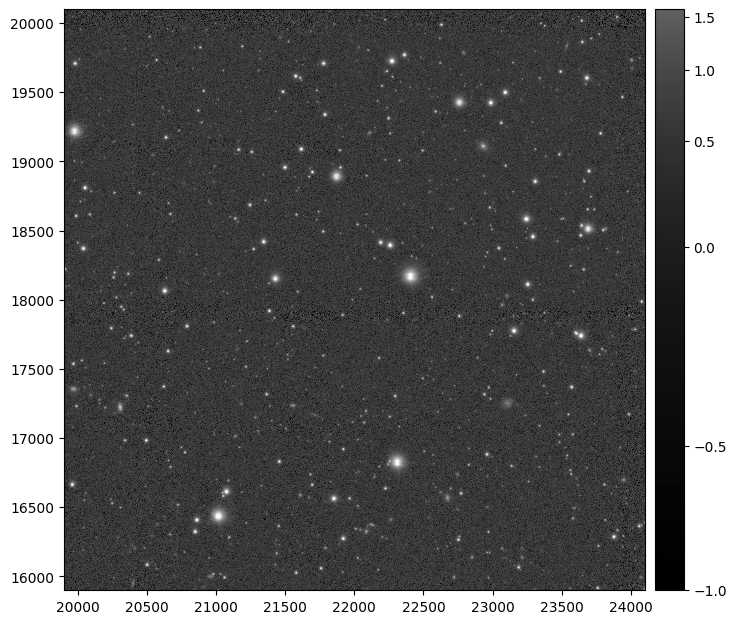

In [40]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(calexp.image)
plt.show()

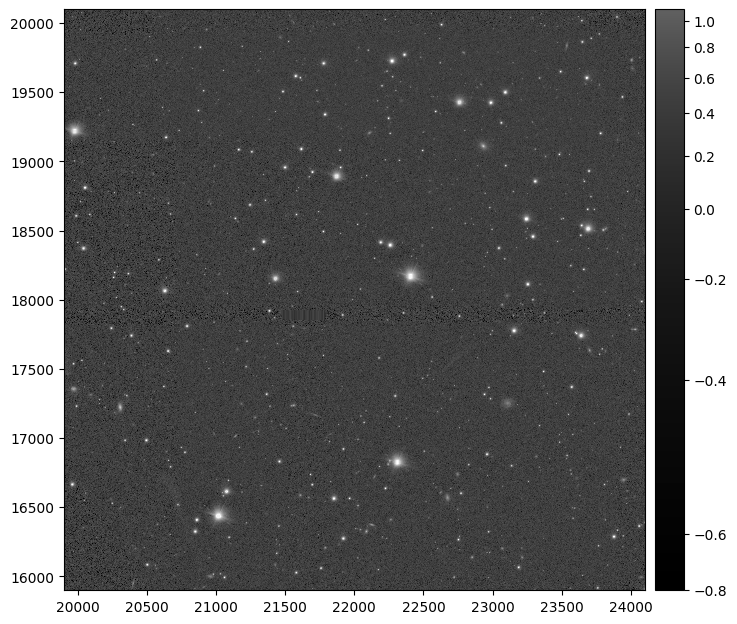

In [41]:
dataId = butler.registry.expandDataId(tract=0, skymap='discrete/ci_hsc', patch=69, band='r')
calexp = butler.get("deepCoadd_calexp", dataId, collections="HSC/runs/ci_hsc")

fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(calexp.image)
plt.show()